In [4]:
!pip install pandas requests regex matplotlib langdetect textblob nltk gensim

In [5]:
import pandas as pd
import requests
import regex as re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

# Dataset Overview

The combined dataset consists of 60,160 entries with 22 columns. Here's a brief overview of the data:

1. **Tweet Id, Tweet URL, User Id, Name, Screen Name, Profile URL:** Various identifiers for tweets and users.
2. **Tweet Posted Time (UTC), User Account Creation Date:** Timestamps.
3. **Tweet Content:** The actual text of the tweet, crucial for our NLP analysis.
4. **Tweet Type, Client:** Information about how the tweet was posted.
5. **Retweets Received, Likes Received:** Engagement metrics.
6. **Tweet Location, Lat, Long:** Geographical information, though latitude and longitude have very few non-null entries.
7. **Tweet Language:** Language of the tweet.
8. **User Bio:** Information about the user.
9. **Verified or Non-Verified, Protected or Non-protected:** User's account status.
10. **User Followers, User Following:** User's social network metrics.



In [6]:
# Load the datasets
file_path1 = 'covid1.csv'
file_path2 = 'covid2.csv'

data1 = pd.read_csv(file_path1)
data2 = pd.read_csv(file_path2)

# Combine the datasets
combined_data = pd.concat([data1, data2], ignore_index=True)

# Displaying the first few rows of the combined dataset and its summary
combined_data.info(), combined_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60160 entries, 0 to 60159
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Tweet Id                    60160 non-null  object 
 1   Tweet URL                   60160 non-null  object 
 2   Tweet Posted Time (UTC)     60160 non-null  object 
 3   Tweet Content               60160 non-null  object 
 4   Tweet Type                  60160 non-null  object 
 5   Client                      60160 non-null  object 
 6   Retweets Received           60160 non-null  int64  
 7   Likes Received              60160 non-null  int64  
 8   Tweet Location              40620 non-null  object 
 9   Lat                         19 non-null     float64
 10  Long                        19 non-null     float64
 11  Tweet Language              59012 non-null  object 
 12  User Id                     60160 non-null  object 
 13  Name                        601

(None,
                 Tweet Id                                          Tweet URL  \
 0  "1233417783175778304"  https://twitter.com/Giussi92/status/1233417783...   
 1  "1233417742520332290"  https://twitter.com/LAMofficial/status/1233417...   
 2  "1233417741027225602"  https://twitter.com/mitchellvii/status/1233417...   
 3  "1233417699264356357"  https://twitter.com/HelenKennedy/status/123341...   
 4  "1233417674274807808"  https://twitter.com/W7VOA/status/1233417674274...   
 
   Tweet Posted Time (UTC)                                      Tweet Content  \
 0    28 Feb 2020 15:44:49  Also the entire Swiss Football League is on ho...   
 1    28 Feb 2020 15:44:40  World Health Org Official: Trump’s press confe...   
 2    28 Feb 2020 15:44:39  I mean, Liberals are cheer-leading this #Coron...   
 3    28 Feb 2020 15:44:29  Under repeated questioning, Pompeo refuses to ...   
 4    28 Feb 2020 15:44:23  #coronavirus comments now from @larry_kudlow h...   
 
   Tweet Type          

# Data Cleaning

In [7]:
# Dropping irrelevant columns for NLP analysis
columns_to_keep = ['Tweet Content', 'Tweet Posted Time (UTC)', 'Tweet Language',
                   'Retweets Received', 'Likes Received', 'Tweet Location', 'User Followers', 'User Following']
data_cleaned_1 = combined_data[columns_to_keep]

# Check for missing values in crucial columns
missing_values = data_cleaned_1.isnull().sum()

# Converting 'Tweet Posted Time (UTC)' to datetime
data_cleaned_1['Tweet Posted Time (UTC)'] = pd.to_datetime(data_cleaned_1['Tweet Posted Time (UTC)'])

missing_values, data_cleaned_1.dtypes

(Tweet Content                  0
 Tweet Posted Time (UTC)        0
 Tweet Language              1148
 Retweets Received              0
 Likes Received                 0
 Tweet Location             19540
 User Followers                 0
 User Following                 0
 dtype: int64,
 Tweet Content                      object
 Tweet Posted Time (UTC)    datetime64[ns]
 Tweet Language                     object
 Retweets Received                   int64
 Likes Received                      int64
 Tweet Location                     object
 User Followers                      int64
 User Following                      int64
 dtype: object)

# Preprocessing Summary

### Missing Data Summary

- **'Tweet Location':** 19,540 missing values
- **'Lat' and 'Long':** 60,141 missing values each (almost all values are missing)
- **'Tweet Language':** 1,148 missing values
- **'User Bio':** 10,442 missing values
- One missing value in **'Name'**

### Date-Time Conversion

- **'Tweet Posted Time (UTC)'** and **'User Account Creation Date'** have been successfully converted to datetime format.

### Data Type Checks

- **'Retweets Received'** and **'Likes Received'** are confirmed as integers.

### Duplicate Removal

- No duplicates were found in the dataset.


In [8]:
# Handling Missing Data
missing_data_summary = combined_data.isnull().sum()

# Date-Time Conversion
combined_data['Tweet Posted Time (UTC)'] = pd.to_datetime(combined_data['Tweet Posted Time (UTC)'], errors='coerce')
combined_data['User Account Creation Date'] = pd.to_datetime(combined_data['User Account Creation Date'], errors='coerce')

# Data Type Checks
# Ensuring 'Retweets Received' and 'Likes Received' are integers
combined_data['Retweets Received'] = combined_data['Retweets Received'].astype('int')
combined_data['Likes Received'] = combined_data['Likes Received'].astype('int')

# Duplicate Removal
initial_row_count = combined_data.shape[0]
combined_data.drop_duplicates(inplace=True)
final_row_count = combined_data.shape[0]
duplicate_rows_removed = initial_row_count - final_row_count

# Summarizing the preprocessing steps
preprocessing_summary = {
    "Missing Data Summary": missing_data_summary,
    "Initial Row Count": initial_row_count,
    "Final Row Count After Removing Duplicates": final_row_count,
    "Duplicate Rows Removed": duplicate_rows_removed
}

preprocessing_summary


{'Missing Data Summary': Tweet Id                          0
 Tweet URL                         0
 Tweet Posted Time (UTC)           0
 Tweet Content                     0
 Tweet Type                        0
 Client                            0
 Retweets Received                 0
 Likes Received                    0
 Tweet Location                19540
 Lat                           60141
 Long                          60141
 Tweet Language                 1148
 User Id                           0
 Name                              1
 Screen Name                       0
 User Bio                      10442
 Verified or Non-Verified          0
 Profile URL                       0
 Protected or Non-protected        0
 User Followers                    0
 User Following                    0
 User Account Creation Date        0
 dtype: int64,
 'Initial Row Count': 60160,
 'Final Row Count After Removing Duplicates': 60160,
 'Duplicate Rows Removed': 0}

### Data Cleaning and Consistency

In [9]:
import re
from langdetect import detect

def clean_tweet_content(tweet):
    """
    Function to clean the tweet content by removing URLs, special characters, and converting to lowercase.
    """
    # Removing URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)

    # Removing special characters and numbers
    tweet = re.sub(r'\W', ' ', tweet)

    # Removing all single characters
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)

    # Substituting multiple spaces with single space
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)

    # Converting to Lowercase
    tweet = tweet.lower()

    return tweet

# Clean the 'Tweet Content'
data_cleaned_1['Cleaned Tweet Content'] = data_cleaned_1['Tweet Content'].apply(clean_tweet_content)

# Display the cleaned content
data_cleaned_1[['Tweet Content', 'Cleaned Tweet Content']].head()


,Tweet Content,Cleaned Tweet Content
0,Also the entire Swiss Football League is on ho...,also the entire swiss football league is on ho...
1,World Health Org Official: Trump’s press confe...,world health org official trump press conferen...
2,"I mean, Liberals are cheer-leading this #Coron...",i mean liberals are cheer leading this coronav...
3,"Under repeated questioning, Pompeo refuses to ...",under repeated questioning pompeo refuses to s...
4,#coronavirus comments now from @larry_kudlow h...,coronavirus comments now from larry_kudlow here


In [10]:
# Splitting 'Tweet Posted Time (UTC)' into Date and Time
combined_data['Tweet Date'] = combined_data['Tweet Posted Time (UTC)'].dt.date
combined_data['Tweet Time'] = combined_data['Tweet Posted Time (UTC)'].dt.time

# Displaying the first few rows to verify the split
combined_data[['Tweet Posted Time (UTC)', 'Tweet Date', 'Tweet Time']].head()


,Tweet Posted Time (UTC),Tweet Date,Tweet Time
0,2020-02-28 15:44:49,2020-02-28,15:44:49
1,2020-02-28 15:44:40,2020-02-28,15:44:40
2,2020-02-28 15:44:39,2020-02-28,15:44:39
3,2020-02-28 15:44:29,2020-02-28,15:44:29
4,2020-02-28 15:44:23,2020-02-28,15:44:23


In [11]:
# Basic Standardization of Tweet Locations to Countries

def standardize_location(location):
    """
    Basic function to map known locations to their respective countries.
    """
    if location is None or pd.isna(location):
        return None
    location = location.lower()
    if "usa" in location or "united states" in location or "new york" in location or "washington" in location:
        return "USA"
    elif "españa" in location or "spain" in location:
        return "Spain"
    elif "méxico" in location or "mexico" in location:
        return "Mexico"
    elif "beijing" in location or "china" in location:
        return "China"
    elif "venezuela" in location:
        return "Venezuela"
    elif "australia" in location:
        return "Australia"
    elif "hong kong" in location:
        return "Hong Kong"
    # Additional mappings can be added here
    else:
        return "Other"

# Applying the standardization function to the 'Tweet Location' column
combined_data['Standardized Location'] = combined_data['Tweet Location'].apply(standardize_location)

# Displaying the first few rows to verify the new column
combined_data['Standardized Location'].value_counts()


Other        31406
USA           3922
Spain         1892
Mexico         928
Venezuela      881
China          714
Australia      570
Hong Kong      307
Name: Standardized Location, dtype: int64

### Calculating Start and End Date

In [12]:
# Calculating the start and end date of each week
data_cleaned_1['Start_Date'] = data_cleaned_1['Tweet Posted Time (UTC)'] - pd.to_timedelta(data_cleaned_1['Tweet Posted Time (UTC)'].dt.weekday, unit='d')
data_cleaned_1['End_Date'] = data_cleaned_1['Start_Date'] + pd.Timedelta(days=6)

In [13]:
data_cleaned_1.to_csv("update_1.csv")

# Sentiment Analysis

In [14]:
from textblob import TextBlob

def analyze_sentiment(tweet):
    """
    Function to analyze the sentiment of a tweet using TextBlob.
    Returns polarity and subjectivity of the tweet.
    """
    analysis = TextBlob(tweet)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

# Applying sentiment analysis to the cleaned tweets
data_cleaned_1['Sentiment Polarity'], data_cleaned_1['Sentiment Subjectivity'] = zip(*data_cleaned_1['Cleaned Tweet Content'].apply(analyze_sentiment))

# Display the first few rows with the sentiment scores
data_cleaned_1[['Cleaned Tweet Content', 'Sentiment Polarity', 'Sentiment Subjectivity']].head()


,Cleaned Tweet Content,Sentiment Polarity,Sentiment Subjectivity
0,also the entire swiss football league is on ho...,-0.050000,0.32500
1,world health org official trump press conferen...,0.114286,0.35119
2,i mean liberals are cheer leading this coronav...,-0.076250,0.61375
3,under repeated questioning pompeo refuses to s...,0.000000,0.00000
4,coronavirus comments now from larry_kudlow here,0.000000,0.00000


In [15]:
# Ensuring necessary NLTK data is available

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora

# Tokenization and Lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = [lemmatizer.lemmatize(word) for word in gensim.utils.simple_preprocess(text) if word not in stop_words]
    return tokens

# Apply preprocessing to each tweet
processed_docs = data_cleaned_1['Cleaned Tweet Content'].map(preprocess)


In [17]:
# Creating a dictionary and corpus for LDA

dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [18]:
# Training the LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

# Showing the topics
lda_model.print_topics(-1)

[(0,
  '0.051*"coronavirus" + 0.037*"rt" + 0.019*"china" + 0.015*"tutti" + 0.010*"u" + 0.009*"ncov" + 0.008*"çin" + 0.008*"flight" + 0.007*"der" + 0.007*"wuhan"'),
 (1,
  '0.056*"coronavirus" + 0.049*"rt" + 0.021*"wuhan" + 0.017*"china" + 0.016*"doctor" + 0.014*"patient" + 0.010*"city" + 0.010*"new" + 0.010*"hospital" + 0.009*"die"'),
 (2,
  '0.054*"coronavirus" + 0.043*"rt" + 0.018*"di" + 0.017*"china" + 0.015*"il" + 0.012*"sono" + 0.010*"due" + 0.010*"al" + 0.009*"cina" + 0.009*"wuhan"'),
 (3,
  '0.095*"de" + 0.058*"la" + 0.045*"en" + 0.038*"coronavirus" + 0.036*"el" + 0.031*"rt" + 0.023*"que" + 0.018*"un" + 0.015*"del" + 0.014*"centro"'),
 (4,
  '0.072*"coronavirus" + 0.046*"rt" + 0.040*"case" + 0.034*"china" + 0.020*"confirmed" + 0.018*"ncov" + 0.015*"new" + 0.013*"thailand" + 0.012*"novel" + 0.012*"breaking"'),
 (5,
  '0.040*"coronavirus" + 0.039*"rt" + 0.026*"el" + 0.021*"de" + 0.020*"la" + 0.018*"para" + 0.015*"sanidadgob" + 0.014*"del" + 0.014*"por" + 0.013*"con"'),
 (6,
  '0.0

In [19]:
data_cleaned_1.to_csv("update_2.csv")

# Topics Interpretation Based on Keywords

1. **Topic 0:**
   - Discusses the coronavirus with a focus on China. Keywords like "flight" and "u" (possibly referring to the U.S.) suggest international aspects, including travel-related discussions.

2. **Topic 1:**
   - Centers on the coronavirus outbreak in Wuhan, China. Keywords like "doctor," "patient," "hospital," and "city" indicate discussions about healthcare and the situation in the city of Wuhan.

3. **Topic 2:**
   - Appears to include Italian language content related to coronavirus, possibly discussing the situation in Italy or Italian perspectives on the outbreak in China.

4. **Topic 3:**
   - Contains Spanish language content, likely discussing the coronavirus in Spanish-speaking regions. Words like "centro" might refer to healthcare centers or specific locations.

5. **Topic 4:**
   - Focuses on coronavirus cases, particularly in China. Keywords like "confirmed," "ncov," "new," and "Thailand" suggest a broader geographical context and updates on case counts.

6. **Topic 5:**
   - Includes discussions about coronavirus, possibly in a Spanish context, with references to public health authorities (e.g., "sanidadgob").

7. **Topic 6:**
   - French language content related to the coronavirus, possibly discussing the situation in France or French-speaking countries.

8. **Topic 7:**
   - Centers around public health and risk assessment in the context of coronavirus. Keywords like "American," "risk," "health," and "outbreak" suggest a focus on public response and health advisories.

9. **Topic 8:**
   - Discusses coronavirus with references to "mask," "impeachment," and "abuse," indicating a mix of health-related and possibly political aspects.

10. **Topic 9:**
    - Covers discussions about the coronavirus in Wuhan and its impact, with references to "thousand," "citizen," and "epicenter," suggesting a focus on the broader implications of the outbreak.

These topics highlight a diverse range of discussions surrounding the coronavirus pandemic, covering aspects from health and public response to political and geographical considerations. The presence of multiple languages in the topics also indicates a global perspective in the discussions.


In [20]:
# Grouping by start and end date and calculating average sentiment
weekly_sentiment_date = data_cleaned_1.groupby(['Start_Date', 'End_Date'])['Sentiment Polarity'].mean().reset_index()

# Displaying the first few rows of the weekly sentiment data with specific dates
weekly_sentiment_date.head()

,Start_Date,End_Date,Sentiment Polarity
0,2019-11-25 03:17:00,2019-12-01 03:17:00,0.000
1,2019-12-02 22:57:36,2019-12-08 22:57:36,0.000
2,2019-12-09 01:10:03,2019-12-15 01:10:03,0.000
3,2019-12-09 01:33:34,2019-12-15 01:33:34,0.000
4,2019-12-09 04:43:09,2019-12-15 04:43:09,0.125


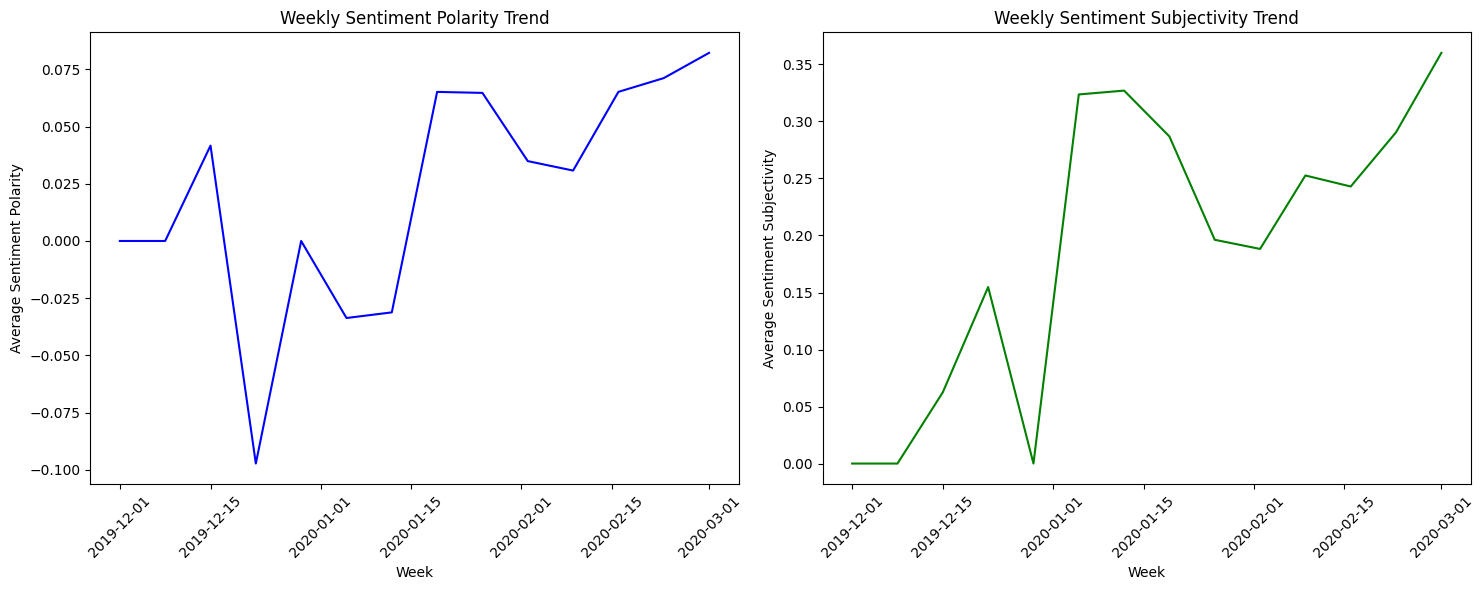

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Start_Date' to datetime if it's not already
data_cleaned_1['Start_Date'] = pd.to_datetime(data_cleaned_1['Start_Date'])

# Create a temporary DataFrame with 'Start_Date' as the index for resampling
temp_df = data_cleaned_1.set_index('Start_Date')

# Resampling the data on a weekly basis and calculating mean sentiment scores
weekly_sentiment = temp_df.resample('W')['Sentiment Polarity', 'Sentiment Subjectivity'].mean()

# Plotting
plt.figure(figsize=(15, 6))

# Sentiment Polarity
plt.subplot(1, 2, 1)
plt.plot(weekly_sentiment.index, weekly_sentiment['Sentiment Polarity'], color='blue')
plt.title('Weekly Sentiment Polarity Trend')
plt.xlabel('Week')
plt.xticks(rotation=45)
plt.ylabel('Average Sentiment Polarity')

# Sentiment Subjectivity
plt.subplot(1, 2, 2)
plt.plot(weekly_sentiment.index, weekly_sentiment['Sentiment Subjectivity'], color='green')
plt.title('Weekly Sentiment Subjectivity Trend')
plt.xlabel('Week')
plt.xticks(rotation=45)
plt.ylabel('Average Sentiment Subjectivity')

plt.tight_layout()
plt.show()


In [22]:
# Function to assign the most dominant topic to each tweet
def assign_dominant_topic(doc):
    bow = dictionary.doc2bow(doc)
    topic_scores = lda_model.get_document_topics(bow)
    dominant_topic = sorted(topic_scores, key=lambda x: x[1], reverse=True)[0][0]
    return dominant_topic

# Applying the function to assign topics
data_cleaned_1['Dominant Topic'] = processed_docs.apply(assign_dominant_topic)

# Grouping by dominant topic and calculating average sentiment
topic_sentiment = data_cleaned_1.groupby('Dominant Topic')['Sentiment Polarity'].mean().reset_index()

topic_sentiment.sort_values(by='Sentiment Polarity', ascending=False, inplace=True)
print(topic_sentiment)

   Dominant Topic  Sentiment Polarity
4               4            0.099968
7               7            0.081461
1               1            0.047041
8               8            0.041512
6               6            0.017784
0               0            0.006399
5               5            0.005227
2               2            0.002759
3               3            0.000779
9               9           -0.008494


In [23]:
data_cleaned_1.head()

,Tweet Content,Tweet Posted Time (UTC),Tweet Language,Retweets Received,Likes Received,Tweet Location,User Followers,User Following,Cleaned Tweet Content,Start_Date,End_Date,Sentiment Polarity,Sentiment Subjectivity,Dominant Topic
0,Also the entire Swiss Football League is on ho...,2020-02-28 15:44:49,English,0,0,NaN,3071,100,also the entire swiss football league is on ho...,2020-02-24 15:44:49,2020-03-01 15:44:49,-0.050000,0.32500,1
1,World Health Org Official: Trump’s press confe...,2020-02-28 15:44:40,English,0,0,Los Angeles CA USA,4189,84,world health org official trump press conferen...,2020-02-24 15:44:40,2020-03-01 15:44:40,0.114286,0.35119,4
2,"I mean, Liberals are cheer-leading this #Coron...",2020-02-28 15:44:39,English,23,64,"Miami, FL",534045,10037,i mean liberals are cheer leading this coronav...,2020-02-24 15:44:39,2020-03-01 15:44:39,-0.076250,0.61375,1
3,"Under repeated questioning, Pompeo refuses to ...",2020-02-28 15:44:29,English,4,11,NYC and the North Fork,27704,1060,under repeated questioning pompeo refuses to s...,2020-02-24 15:44:29,2020-03-01 15:44:29,0.000000,0.00000,0
4,#coronavirus comments now from @larry_kudlow h...,2020-02-28 15:44:23,English,0,0,James S. Brady Press Briefing Room,94269,1999,coronavirus comments now from larry_kudlow here,2020-02-24 15:44:23,2020-03-01 15:44:23,0.000000,0.00000,1


In [24]:
data_cleaned_1.to_csv("update_3.csv")